<a href="https://colab.research.google.com/github/Svsshevch/traffic-sign-project/blob/main/detection_(1)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Detection model

We make a traffic sign detection model based on YOLOv8. The detector is trained on the GTSDB dataset to localize traffic signs in video frames as a single class. The detected regions are then used as input for a CNN-based classifier, forming a two-stage detection–classification pipeline.

In [ ]:
!pip install ultralytics


In [2]:
import time
import torch
import os
import shutil
from ultralytics import YOLO
import yaml
import matplotlib.pyplot as plt
import cv2
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
from PIL import Image
import random
#torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


##Download Dataset

In [ ]:
!wget https://sid.erda.dk/public/archives/ff17dc924eba88d5d01a807357d6614c/FullIJCNN2013.zip


In [4]:
!unzip -q FullIJCNN2013.zip

In [5]:
os.rename("FullIJCNN2013", "GTSDB")
GTSDB_PATH = "GTSDB"

In [ ]:
#!rm -rf GTSDB

##Upload CNN Model

We define the CNN model responsible for traffic sign classification in the detection pipeline.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TrafficSignCNN(nn.Module):
    def __init__(self, num_classes=43):
        super().__init__()

        #Layer 1: 64x64x3 to 32x32x64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        #Layer 2: 32x32x64 to 32x32x128
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        #Layer 3: 32x32x128 to 16x16x256
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        #Layer 4: 16x16x256 to 8x8x512
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)

        #Layer 5: 8x8x512 to 8x8x512
        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(2, 2)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(512, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        #Conv -> BN -> ReLU -> Pool
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)

        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)

        x = F.relu(self.bn5(self.conv5(x)))

        #Global pooling and flatten
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)

        #Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        x = self.fc3(x)

        return x

class_names = [
    "Speed limit (20km/h)",
    "Speed limit (30km/h)",
    "Speed limit (50km/h)",
    "Speed limit (60km/h)",
    "Speed limit (70km/h)",
    "Speed limit (80km/h)",
    "End of speed limit (80km/h)",
    "Speed limit (100km/h)",
    "Speed limit (120km/h)",
    "No passing",
    "No passing for vehicles over 3.5 metric tons",
    "Right-of-way at the next intersection",
    "Priority road",
    "Yield",
    "Stop",
    "No vehicles",
    "Vehicles over 3.5 metric tons prohibited",
    "No entry",
    "General caution",
    "Dangerous curve to the left",
    "Dangerous curve to the right",
    "Double curve",
    "Bumpy road",
    "Slippery road",
    "Road narrows on the right",
    "Road work",
    "Traffic signals",
    "Pedestrians",
    "Children crossing",
    "Bicycles crossing",
    "Beware of ice/snow",
    "Wild animals crossing",
    "End of all speed and passing limits",
    "Turn right ahead",
    "Turn left ahead",
    "Ahead only",
    "Go straight or right",
    "Go straight or left",
    "Keep right",
    "Keep left",
    "Roundabout mandatory",
    "End of no passing",
    "End of no passing by vehicles over 3.5 metric tons"
]

class_names= sorted(class_names)

#Got mean and std from CNN model file
MEAN = [0.3441, 0.3210, 0.3325]
STD  = [0.2766, 0.2673, 0.2755]

cnn_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])

def load_cnn_model(model_path='my_traffic_sign_model.pth'):
    model = TrafficSignCNN(num_classes=43)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

We load a pretrained CNN classification model that was trained earlier and saved using Weights & Biases.

In [ ]:
!pip install wandb

In [ ]:
import wandb
import os

wandb.login()

artifact = wandb.Api().artifact("svsshevchenko/Traffic_Sign_Classificator/final-model:latest")
artifact_dir = artifact.download()

weights_path = os.path.join(artifact_dir, "my_traffic_sign_model.pth")
print("Downloaded:", weights_path)
print("Exists:", os.path.exists(weights_path))

#load it
cnn_model = load_cnn_model(weights_path)

##Building a Dataset

We convert the GTSDB dataset into YOLO format, which is required in order to train a YOLOv8.

The function first creates the required images and labels directories. It then reads the ground truth annotations from gt.txt and groups all bounding boxes belonging to the same image. Since the detection task focuses only on localizing traffic signs, all original class labels are ignored and replaced with a single class (traffic_sign).

Then the images are copied and converted from .ppm to .jpg. The bounding box coordinates are transformed from pixel-based format to YOLO’s normalized representation (center coordinates, width, and height) and saved into individual label files

In [9]:
def convert_gtsdb_to_yolo(gtsdb_path, output_path):

    images_dir = os.path.join(output_path, 'images')
    labels_dir = os.path.join(output_path, 'labels')
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)

    gt_file = os.path.join(gtsdb_path, 'gt.txt')

    #map images to their boxes
    image_data = {}

    with open(gt_file, 'r') as f:
        for line in f:
            parts = line.strip().split(';')
            if len(parts) < 6:
                continue

            img_name = parts[0]
            x1, y1, x2, y2 = map(int, parts[1:5])
            class_id = 0

            if img_name not in image_data:
                image_data[img_name] = []

            image_data[img_name].append([class_id, x1, y1, x2, y2])

    for img_name, boxes in image_data.items():
        #copy image
        src_img = os.path.join(gtsdb_path, img_name)
        dst_img = os.path.join(images_dir, img_name.replace('.ppm', '.jpg'))

        #convert
        img = Image.open(src_img)
        img.save(dst_img)

        #label file
        label_file = os.path.join(labels_dir, img_name.replace('.ppm', '.txt'))

        with open(label_file, 'w') as f:
            img_w, img_h = img.size

            for box in boxes:
                class_id, x1, y1, x2, y2 = box

                #convert to YOLO format: center_x, center_y, width, height
                center_x = ((x1 + x2) / 2) / img_w
                center_y = ((y1 + y2) / 2) / img_h
                width = (x2 - x1) / img_w
                height = (y2 - y1) / img_h

                #write to file
                f.write(f"{class_id} {center_x:.6f} {center_y:.6f} {width:.6f} {height:.6f}\n")

    print(f"Converted {len(image_data)} images to YOLO format")
    return output_path

This function splits the dataset into training and validation subsets. It first creates the required directory structure (images/train, images/val, labels/train, labels/val). The images are then randomly shuffled and divided according to the validation ratio = 0.2.

Each image is moved together with its corresponding label file to maintain consistency between images and annotations. If a label file is missing, an empty file is created to mark images without objects, ensuring YOLO processes all images correctly and learns both object and background representations without errors

In [10]:
import os, random, shutil

def split_yolo_dataset(base="gtsdb_yolo_format", val_ratio=0.2, seed=42):
    random.seed(seed)

    images_dir = base + "/images"
    labels_dir = base + "/labels"

    os.makedirs(images_dir + "/train", exist_ok=True)
    os.makedirs(images_dir + "/val", exist_ok=True)
    os.makedirs(labels_dir + "/train", exist_ok=True)
    os.makedirs(labels_dir + "/val", exist_ok=True)

    images = [f for f in os.listdir(images_dir)
              if f.endswith(".jpg") and os.path.isfile(images_dir + "/" + f)]

    print("Images in images/:", len(images))

    random.shuffle(images)
    split = int((1 - val_ratio) * len(images))
    train_images = images[:split]
    val_images = images[split:]

    def move_pair(img_name, split_name):
        src_img = images_dir + "/" + img_name
        src_lbl = labels_dir + "/" + img_name.replace(".jpg", ".txt")

        dst_img = images_dir + f"/{split_name}/" + img_name
        dst_lbl = labels_dir + f"/{split_name}/" + img_name.replace(".jpg", ".txt")

        shutil.move(src_img, dst_img)

        #if label missing, create empty
        if os.path.exists(src_lbl):
            shutil.move(src_lbl, dst_lbl)
        else:
            open(dst_lbl, "w").close()

    for img in train_images:
        move_pair(img, "train")
    for img in val_images:
        move_pair(img, "val")

    print("Done split! Train:", len(train_images), "Val:", len(val_images))


We make the dataset configuration file (dataset.yaml), defining where the training and validation data are located and how detection classes are interpreted

In [11]:
def create_yaml_file(output_path, data_yaml_path):
    data = {
        'path': os.path.abspath(output_path),
         "train": "images/train",
        "val": "images/val",
        'names': {
            0: 'traffic_sign'
        }
    }

    with open(data_yaml_path, 'w') as f:
        yaml.dump(data, f)

    print(f"Created dataset YAML at {data_yaml_path}")
    return data_yaml_path


##Training the traffic sign detector

The training process is controlled through several key hyperparameters. A pretrained YOLOv8 nano model is used. The input image size (imgsz=640) is chosen to improve the detection of small objects, such as distant traffic signs. Since higher image resolution increases memory consumption, a moderate batch size of 16 is selected to ensure stable training.

Data augmentation techniques, such as mosaic and mixup, are applied. Mosaic augmentation combines four different training images into a single image by placing them in a 2*2 grid. As a result, objects appear at different scales and positions within the same image.

In [ ]:
NUM_EPOCHS = 20
BATCH_SIZE = 16
MOSAIC = 0.3
IMGSZ = 640

In [ ]:
import wandb

wandb.init(
    project="Traffic_Sign_Detection",
    name="YOLOv8_GTSDB",
    config={
        "model": "yolov8n",
        "imgsz": 640,
        "batch": BATCH_SIZE,
        "epochs": NUM_EPOCHS,
        "mosaic": 0.3
    }
)

In [ ]:
def train_yolo(data_yaml_path):
    model = YOLO('yolov8n.pt')

    results = model.train(
        data=data_yaml_path,
        epochs=NUM_EPOCHS,
        imgsz=IMGSZ,
        batch=BATCH_SIZE,
        name='gtsdb_traffic_signs',
        pretrained=True,
        device="cpu",
        mosaic=MOSAIC,
        project="Traffic_Sign_Detection"
    )

    return model


In [ ]:
def main():
    GTSDB_PATH = 'GTSDB'
    OUTPUT_PATH = 'gtsdb_yolo_format'
    DATA_YAML = 'gtsdb_dataset.yaml'

    print("Converting GTSDB to YOLO format")
    convert_gtsdb_to_yolo(GTSDB_PATH, OUTPUT_PATH)

    print("Splitting into train/val")
    split_yolo_dataset(base=OUTPUT_PATH, val_ratio=0.2)

    print("Creating dataset YAML")
    create_yaml_file(OUTPUT_PATH, DATA_YAML)

    print("Training YOLO model")
    model = train_yolo(DATA_YAML)

    print("\nTraining completed!")
    print("Best model saved at: runs/detect/gtsdb_traffic_signs/weights/best.pt")
    return model

In [ ]:
# if __name__ == "__main__":
#     model = main()

##Evaluation metrics

**Loss functions:**

* **Bounding box loss**\
Measures how accurately the predicted bounding boxes
match the ground-truth boxes.\
Both training and validation losses decrease steadily and remain close to each. The model does not overfit and localization performance generalizes well to unseen data.

* **Classification loss**\
Since the detection model is trained with only one class, the classification loss measures the model's ability to distinguish traffic signs from background.\
It shows a rapid decrease during the early epochs for both training and validation, followed by a stable plateau, which is expected in a single class detection task.

* **Distribution Focal Loss**\
Reflects bounding box edge predictions by modeling them as probability distributions.\
The validation DFL loss shows small fluctuations, especially in early epochs, due to the limited size of the validation set and the difficulty of precise localization for small traffic signs. But since val/train curves follow a similar downward trend and remain close, these fluctuations do not indicate overfitting.


**Precision**\
Precision indicates how many of the detected objects are actually traffic signs.

The final model achieved a precision of 0.943, indicating a very low false-positive rate.

**Recall**\
Indicates how many real traffic signs present in the image are successfully detected.

Final recall value of 0.889 shows that the majority of traffic signs present in the validation set were correctly identified.

**Mean Average Precision (mAP)**

* **mAP@50**\
Measures detection performance when a predicted bounding box is considered correct if its Intersection over Union (IoU) with the ground truth is at least 0.5. This metric evaluates whether the object is detected approximately correctly.\
Final mAP@50 score is 0.941. This result confirms that the detector generally identifies traffic signs correctly and places bounding boxes in reasonable locations.

* **mAP@50–95**\
Computes the average precision over multiple IoU thresholds from 0.50 to 0.95.\
mAP@50–95 score of 0.755 reveals a drop in performance when precise localization is required.

The difference between mAP@50 and mAP@50–95 shows that the model usually detects traffic signs correctly, but the predicted bounding boxes are not always very tight.


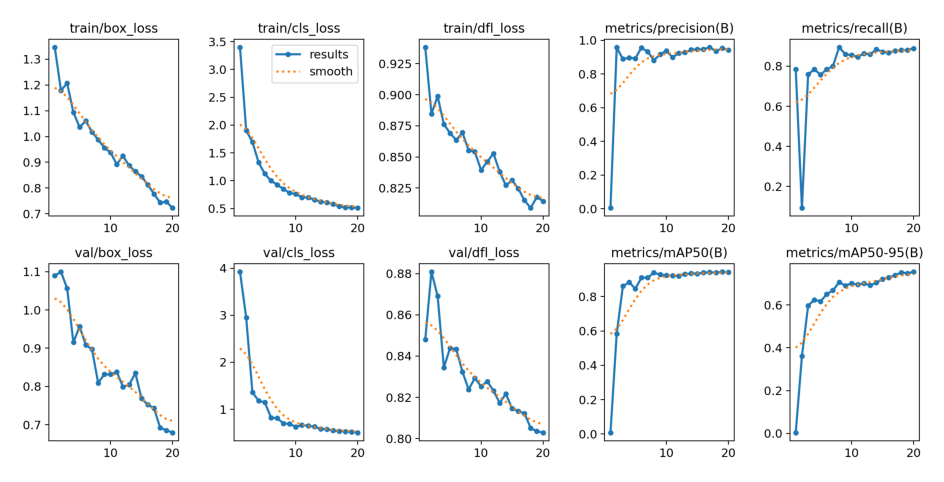

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

run_dir = "runs/detect/Traffic_Sign_Detection/gtsdb_traffic_signs3"
img = Image.open(f"{run_dir}/results.png")

plt.figure(figsize=(12, 6))
plt.imshow(img)
plt.axis("off")
plt.show()

In [ ]:
artifact = wandb.Artifact(
    name="yolo-traffic-sign-detector",
    type="model",
)

artifact.add_file("runs/detect/Traffic_Sign_Detection/gtsdb_traffic_signs/weights/best.pt")
wandb.log_artifact(artifact)
run_dir = "runs/detect/Traffic_Sign_Detection/gtsdb_traffic_signs"
plot_path = os.path.join(run_dir, "results.png")

wandb.log({"YOLO_training_curves": wandb.Image(plot_path)})
wandb.finish()

##Real-time traffic sign recognition using webcam
We implement the final real-time inference stage of the project, where the system is tested on live webcam input. The function combines two previously trained components into a single pipeline: a YOLOv8 detector that localizes traffic signs in each frame and a CNN classifier that predicts the specific traffic sign category from the cropped regio

###Upload the best YOLO checkpoint
This block downloads a trained YOLO model checkpoint (best.pt) from Weights & Biases Artifacts and returns the local file path to that checkpoint.

In [12]:
import os
from pathlib import Path
import wandb
from ultralytics import YOLO

def download_yolo_bestpt_from_wandb(artifact_name: str) -> str:
  api = wandb.Api()
  artifact = api.artifact(artifact_name, type="model")
  artifact_dir = Path(artifact.download())

  best_pt = artifact_dir / "best.pt"
  if not best_pt.exists():
      raise FileNotFoundError(f"best.pt not found at {best_pt}")

  return str(best_pt)

In [13]:
yolo_bestpt = download_yolo_bestpt_from_wandb("svsshevchenko/Traffic_Sign_Detection/yolo-traffic-sign-detector:latest")
yolo_model = YOLO(yolo_bestpt)

wandb:   2 of 2 files downloaded.  


First, a YOLO detector locates traffic signs in each frame and filters detections by confidence. Second, each detected region is cropped, converted to RGB, preprocessed with the same transforms as in training, and classified by a CNN into one of 43 traffic-sign classes. Predictions are displayed only when both YOLO and CNN confidence exceed predefined thresholds (0.7, 0.7), reducing wrong predictions in real time.

In [ ]:
def webcam_detection(cnn_model_path=weights_path):
    cnn_model = TrafficSignCNN(num_classes=43)
    cnn_model.load_state_dict(torch.load(cnn_model_path, map_location=device))
    cnn_model.to(device)
    cnn_model.eval()

    transform = cnn_transform

    cap = cv2.VideoCapture(0)

    print("Webcam started. Press 'q' to quit.")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        results = yolo_model(frame, verbose=False)

        for result in results:
            for box in result.boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                yolo_conf = box.conf[0].item()

                if yolo_conf < 0.7:
                    continue
                sign_region = frame[y1:y2, x1:x2]
                if sign_region.size == 0:
                    continue

                sign_pil = Image.fromarray(cv2.cvtColor(sign_region, cv2.COLOR_BGR2RGB))

                try:
                    img_tensor = transform(sign_pil).unsqueeze(0).to(device)
                except:
                    continue

                with torch.no_grad():
                    output = cnn_model(img_tensor)
                    probabilities = F.softmax(output, dim=1)[0]
                    pred_class = probabilities.argmax().item()
                    confidence = probabilities[pred_class].item()

                print(f"YOLO: {yolo_conf:.2f}, CNN: {confidence:.2f}, Class: {pred_class}")

                #Get top prediction
                if confidence > 0.7:
                    pred_name = class_names[pred_class] if pred_class < len(class_names) else f"Class {pred_class}"

                    #Draw CNN result
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    label = f"C: {pred_name[:10]} {confidence:.2f}"
                    cv2.putText(frame, label, (x1, y1-10),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        cv2.imshow('Traffic Sign Detection', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

In [ ]:
if __name__ == "__main__":
    webcam_detection()

##Video-Based Traffic Sign Detection and Classification

We apply the trained traffic sign detection and classification pipeline to a real driving video recorded in Vienna. The goal is to evaluate the model's performance on realistic road scenes outside the training dataset.

To improve computational efficiency and reduce processing time, the video is downsampled to 25 frames per second by skipping frames, and only the first 3 minutes of the video are analyzed.

For each detection where both the YOLO detector and the CNN classifier exceed a confidence threshold of 0.7, the corresponding bounding box and predicted class label are drawn directly onto the video frame. The annotated frames are then written to a new output video file, enabling visual inspection of the detection and classification results.

In [14]:
def process_videos(video_path="Driving_Into_the_Heart_of_Vienna_–_From_District_4_to_the_Historic.mp4", cnn_model_path=weights_path):

    cnn_model = TrafficSignCNN(num_classes=43)
    cnn_model.load_state_dict(torch.load(cnn_model_path, map_location=device))
    cnn_model.to(device)
    cnn_model.eval()

    transform = cnn_transform


    cap = cv2.VideoCapture(video_path)
    original_fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    #Crop: first 3 minutes (180 seconds)
    max_frames = 180 * original_fps

    #reduce fps 60 to 25
    target_fps = 25
    skip_factor = max(1, original_fps // target_fps)

    output_path = video_path.replace('.mp4', f'_detected_{target_fps}fps_5min.mp4')
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, target_fps, (width, height))

    frame_count = 0
    processed_frames = 0

    while True:
        ret, frame = cap.read()
        if not ret or frame_count >= max_frames:
            break

        #skip frames to reduce FPS
        if frame_count % skip_factor == 0:
            results = yolo_model(frame, verbose=False)

            for result in results:
                for box in result.boxes:
                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    yolo_conf = box.conf[0].item()

                    if yolo_conf < 0.7:
                        continue

                    sign_region = frame[y1:y2, x1:x2]
                    if sign_region.size == 0:
                        continue

                    sign_pil = Image.fromarray(cv2.cvtColor(sign_region, cv2.COLOR_BGR2RGB))

                    try:
                        img_tensor = transform(sign_pil).unsqueeze(0).to(device)
                    except:
                        continue

                    with torch.no_grad():
                        output = cnn_model(img_tensor)
                        probabilities = F.softmax(output, dim=1)[0]
                        pred_class = probabilities.argmax().item()
                        confidence = probabilities[pred_class].item()

                    if confidence > 0.7:
                        pred_name = class_names[pred_class] if pred_class < len(class_names) else f"Class {pred_class}"
                        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                        label = f"{pred_name[:10]} {confidence:.2f}"
                        cv2.putText(frame, label, (x1, y1-10),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

            out.write(frame)
            processed_frames += 1

        frame_count += 1

        if frame_count % 100 == 0:
            print(f"  Frames: {frame_count}/{max_frames} (processed {processed_frames})", end='\r')

    cap.release()
    out.release()
    print(f"\n✓ Saved: {os.path.basename(output_path)} ({processed_frames} frames at {target_fps}fps)")







In [15]:
if __name__ == "__main__":
    process_videos()


✓ Saved: Driving_Into_the_Heart_of_Vienna_–_From_District_4_to_the_Historic_detected_25fps_5min.mp4 (3696 frames at 25fps)
